# Tarefa 02
Nesta tarefa vocês irão projetar duas arquiteturas de CNN utilizando os conceitos, camadas e técnicas vistas no curso. As redes serão treinadas no dataset CIFAR-10 e depois comparadas. As tarefas são:

**1) Definir as arquiteturas; ----> 0.3 pontos** 

- Quantas [camadas](https://keras.io/layers/core/) ela terá?
- Quais as operações utilizadas (convoluções, pooling, fully-connected)?
- Quais serão os parâmetros de cada camada (número e tamanho dos filtros convolucionais, stride, tamanho do pooling, funções de ativação)?
- Que tipo de [inicialização](https://keras.io/initializers/) de pesos você utilizará?
- Haverá dropout? Qual a taxa de dropout? 
- Haverá [regularização](https://keras.io/regularizers/)? Qual a taxa do regularizador?

**2) Definir como será o treino; ----> 0.25 pontos**
- Número de épocas e tamanho do batch (deixe igual p/ as duas redes);
- [Otimizador](https://keras.io/optimizers/);
- [Função de custo](https://keras.io/losses/);

**3) Classificar o conjunto de teste e comparar os resultados; ----> 0.25 pontos**
- Classificar imagens de teste;
- Comparar acurácias;
- Plotar loss pelo número de épocas no conjunto de treinamento e validação de cada rede. 
    
**4) Escrever um parágrafo com as suas conclusões; ----> 0.2 pontos**

-----

## CIFAR-10
Este conjunto de dados é composto de 60000 imagens coloridas de dimensões 32x32, divididas em 10 classes (com 6000 imagens por classe), sendo 50000 para treinamento e 10000 para teste. As classes do CIFAR-10 são **aviões, automóveis, pássaros, gatos, alces, cachorros, sapos, cavalos, navios, caminhões.**

O código abaixo carrega e transforma os dados de entrada para ficarem prontos para serem treinados/classificados pela sua rede. Os conjuntos de treino, validação e teste estão balanceados, portanto a acurácia já estará normalizada nos métodos do Keras.  

In [9]:
#Imports
import os
import numpy as np
from random import seed
seed(42)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,15) # Make the figures a bit bigger

from keras.datasets import cifar10
from keras.utils import np_utils
from sklearn.cross_validation import StratifiedShuffleSplit


#Load data
(trainVal_data, trainVal_label), (X_test, y_test) = cifar10.load_data()

#Split trainVal data into train and val sets (already balanced)
splitIdx = StratifiedShuffleSplit(trainVal_label, 1, test_size=10000, random_state=0)
for train_index, val_index in splitIdx:
    X_train, X_val = trainVal_data[train_index], trainVal_data[val_index]
    y_train, y_val = trainVal_label[train_index], trainVal_label[val_index]
    
    
#Transform data
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_val = X_val.reshape(X_val.shape[0], 32, 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_val /= 255
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Validation matrix shape", X_val.shape)
print("Testing matrix shape", X_test.shape)

Y_train = np_utils.to_categorical(y_train, 10)
Y_val = np_utils.to_categorical(y_val, 10)
Y_test = np_utils.to_categorical(y_test, 10)

Training matrix shape (40000, 32, 32, 3)
Validation matrix shape (10000, 32, 32, 3)
Testing matrix shape (10000, 32, 32, 3)


--------
--------
--------
**A tarefa de vocês começa aqui!!!**

# Definir as duas arquiteturas - [0.3 pontos]
***Não se esqueçam de***:
    - Importar as camadas utilizadas e o tipo do modelo (Sequential);
    - Passar o input_shape na primeira camada da rede;
    - Utilizar ativação `softmax` na última camada densa da rede;

In [0]:
#Imports
from typing import Optional, Tuple, List, NamedTuple
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, SpatialDropout2D, concatenate, Add
from keras.preprocessing.image import ImageDataGenerator
#from keras import optimizers # other stuff needed ... 

In [0]:
# Define 1st architecture
def createModel1():
    #This simplest architecture: just applies tiny 3x3 convolutions + MaxPooling + Dropout until 
    #The data is reduced to a single pixel
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(SpatialDropout2D(0.2))

    model.add(Conv2D(48, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(SpatialDropout2D(0.2))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(SpatialDropout2D(0.2))

    model.add(Conv2D(48, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(SpatialDropout2D(0.2))
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(SpatialDropout2D(0.2))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dense(10, activation='softmax'))
    return model

In [0]:
# Define 2nd architecture
class FireCeption:
    # Something of a mixup between a Fire and Inception layers:
    # - Initial (optional) squeeze reduces number of input features
    # - Several stacks composed of (optional) MaxPooling, (optional) bottleneck and convolution
    # - All results are concatenated 
    # - Dropout is optionally applied
    # - Input is optionally added (To force the layer to calculate residuals)

    class Stack(NamedTuple):
        outputs: int
        bottleneck: Optional[int] = None
        maxPooling: Optional[Tuple[int, int]] = None
        conv: Tuple[int, int] = (1, 1)

        def build(self, input, strides=(1,1), name='FireCeption.Stack'):
            x = input
            if self.bottleneck is not None:
                x = Conv2D(self.bottleneck, kernel_size=(1,1), padding='same', activation='relu', name=f'{name}/bottleneck')(x)
            if self.maxPooling is not None:
                x = MaxPooling2D(pool_size=self.maxPooling, strides=(1,1), padding='same', name=f'{name}/maxPooling')(x)
            x = Conv2D(self.outputs, kernel_size=self.conv, strides=strides, activation='relu', padding='same', name=f'{name}/conv')(x)
            return x
        
    @staticmethod
    def Layer(input, squeeze:Optional[int]=None, stacks:List['FireCeption.Stack']=[], strides=(1,1), dropout:float=None, residual=None, name:str='FireCeption'):
        squeeze_layer = input if squeeze is None else Conv2D(squeeze, kernel_size=(1,1), padding='same', activation='relu', name=f'{name}/squeeze')(input)
        stack_layers = [
            stack.build(squeeze_layer, strides=strides, name=f'{name}/{i}')
            for i, stack in enumerate(stacks)
        ]
        concat_layer = concatenate(stack_layers, axis=3, name=f'{name}/concat')
        dropout_layer = concat_layer if dropout is None else SpatialDropout2D(dropout)(concat_layer)
        residual_layer = dropout_layer if residual is None else Add()([residual, dropout_layer])
        return residual_layer

def createModel2():
    input = Input(shape=(32, 32, 3)) #placeholder
    x = input
    
    x = FireCeption.Layer(
        input=x,
        name='FireCeption-in',
        dropout=0.2,
        strides=(1,1),
        stacks=[
            FireCeption.Stack(conv=(1,1), outputs=16),
            FireCeption.Stack(conv=(3,3), outputs=16),
            FireCeption.Stack(conv=(5,5), outputs=16),
            FireCeption.Stack(maxPooling=(3,3), outputs=16)
        ])
    
    for i in range(5):
        x1 = FireCeption.Layer(
            input=x,
            name=f'FireCeption-{i}A',
            squeeze=32,
            dropout=0.2,
            stacks=[
                FireCeption.Stack(conv=(1,1), outputs=16),
                FireCeption.Stack(conv=(3,3), outputs=16),
                FireCeption.Stack(conv=(5,5), outputs=16),
                FireCeption.Stack(maxPooling=(3,3), outputs=16)
            ])
        x2 = FireCeption.Layer(
            input=x1,
            name=f'FireCeption-{i}B',
            squeeze=32,
            dropout=0.2,
            residual=x,
            stacks=[
                FireCeption.Stack(conv=(1,1), outputs=16),
                FireCeption.Stack(conv=(3,3), outputs=16),
                FireCeption.Stack(conv=(5,5), outputs=16),
                FireCeption.Stack(maxPooling=(3,3), outputs=16)
            ])
        x = AveragePooling2D(pool_size=(2,2))(x2)
    
            
    x = GlobalAveragePooling2D()(x)
    x = Dense(10, activation='softmax')(x)
    return Model(inputs=input, outputs=x)

In [0]:
models = {
    'One': createModel1(),
    'Two': createModel2(),
}

# Treinamento - [0.25 pontos]
***Não se esqueçam de***:
    - Escolher otimizador e loss;
    - Compilar o modelo;
    - Definir número de épocas, tamanho do batch (utilizar o mesmo para ambas as redes);
    - Passar o conjunto de validação em `validation_data`;

In [14]:
def do_train(name, model):
    print(f'trainning model {name}:  {model.count_params()} parameters')
    
    #Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    #Data augmentation
    trainDataGen = ImageDataGenerator(
            horizontal_flip=True, 
            zoom_range=0.05, 
            fill_mode='nearest',
            rotation_range=10)
    
    
    #Early stopping
    earlystop = EarlyStopping(monitor='val_acc', #metric to monitor
                          min_delta=0.001,  #difference considered as improvement
                          patience=5) #number of epochs with no improvement after which training will be stopped 
    
    #Train CNN
    return model.fit_generator(
            trainDataGen.flow(X_train, Y_train, batch_size=100),
            steps_per_epoch=len(X_train) / 100, 
            epochs=100,
            verbose=1,
            validation_data=(X_val, Y_val),
            callbacks=[earlystop])

train_history = {
    name: do_train(name, model)
    for name, model in models.items()
}

trainning model One:  84362 parameters
Epoch 1/100
400/400 [==============================] - 28s 71ms/step - loss: 2.0070 - acc: 0.2489 - val_loss: 1.6327 - val_acc: 0.3962
Epoch 2/100
187/400 [=============>................] - ETA: 12s - loss: 1.6960 - acc: 0.3752400/400 [==============================] - 25s 63ms/step - loss: 1.6530 - acc: 0.3940 - val_loss: 1.4630 - val_acc: 0.4793
Epoch 3/100
389/400 [============================>.] - ETA: 0s - loss: 1.5305 - acc: 0.4427400/400 [==============================] - 26s 64ms/step - loss: 1.5287 - acc: 0.4428 - val_loss: 1.3591 - val_acc: 0.5051
Epoch 4/100
400/400 [==============================] - 26s 64ms/step - loss: 1.4522 - acc: 0.4780 - val_loss: 1.2546 - val_acc: 0.5475
Epoch 5/100
 43/400 [==>...........................] - ETA: 19s - loss: 1.3812 - acc: 0.4970400/400 [==============================] - 26s 64ms/step - loss: 1.3972 - acc: 0.4985 - val_loss: 1.2287 - val_acc: 0.5638
Epoch 6/100
326/400 [=======================>..

 21/400 [>.............................] - ETA: 58s - loss: 1.4473 - acc: 0.4800400/400 [==============================] - 65s 162ms/step - loss: 1.4290 - acc: 0.4767 - val_loss: 1.2897 - val_acc: 0.5258
Epoch 7/100
322/400 [=======================>......] - ETA: 12s - loss: 1.4022 - acc: 0.4880400/400 [==============================] - 65s 163ms/step - loss: 1.3961 - acc: 0.4908 - val_loss: 1.2194 - val_acc: 0.5613
Epoch 8/100
400/400 [==============================] - 65s 162ms/step - loss: 1.3533 - acc: 0.5070 - val_loss: 1.2315 - val_acc: 0.5543
Epoch 9/100
 20/400 [>.............................] - ETA: 59s - loss: 1.3103 - acc: 0.5110400/400 [==============================] - 65s 163ms/step - loss: 1.3226 - acc: 0.5164 - val_loss: 1.1734 - val_acc: 0.5734
Epoch 10/100
320/400 [=======================>......] - ETA: 12s - loss: 1.2934 - acc: 0.5296400/400 [==============================] - 65s 162ms/step - loss: 1.2885 - acc: 0.5309 - val_loss: 1.1299 - val_acc: 0.5965
Epoch 11/10

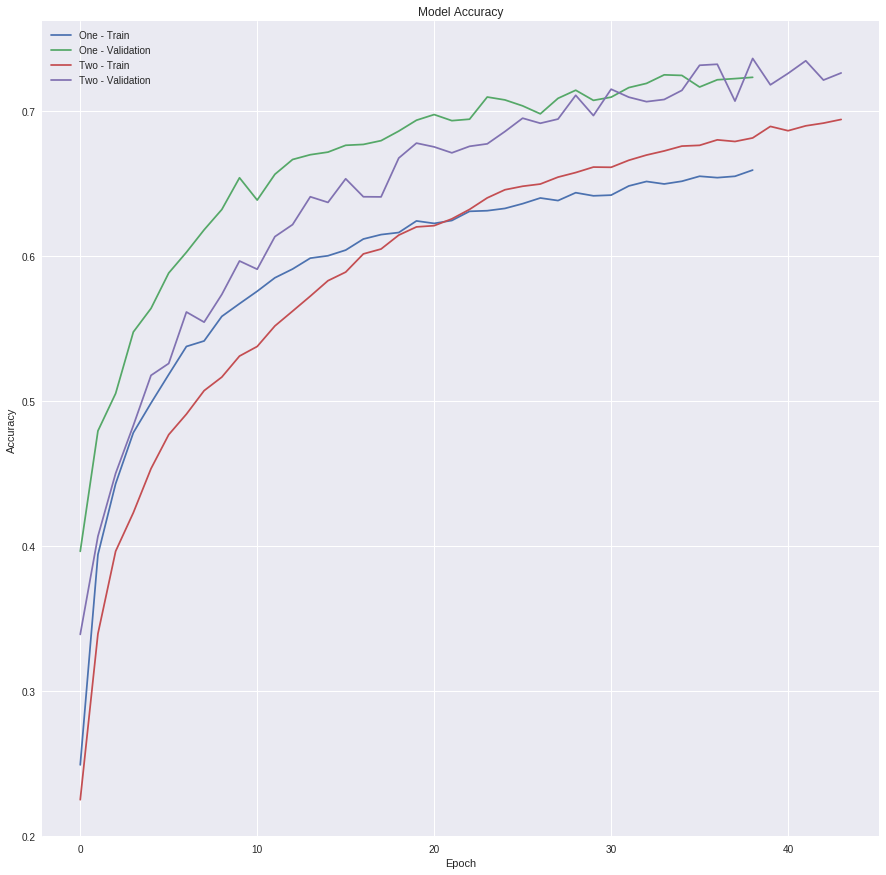

In [20]:
legends=[]
for name, history in train_history.items():
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    legends += [
        f'{name} - Train', 
        f'{name} - Validation'
    ]

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(legends, loc='upper left')
plt.show()

# Resultados no conjunto de teste [0.25 pontos]
***Não se esqueçam de***:
    - Classificar as imagens do conjunto de teste utilizando cada rede;
    - Computar acurácia para cada rede;
    - Comparar ambas as acurácias;
    - Plotar loss pelo número de épocas no conjunto de treinamento e validação de cada rede. 

In [17]:
for name, model in models.items():
    print(f'testing model {name}')
    score = model.evaluate(X_test, Y_test, verbose=1)
    print('Accuracy:', score[1])

testing model One
10000/10000 [==============================] - 1s 129us/step
Accuracy: 0.7202
testing model Two
10000/10000 [==============================] - 5s 506us/step
Accuracy: 0.7259


# Conclusões [0.2 pontos]
Escrevam um parágrafo com as conclusões que vocês tiraram na tarefa. Comentem as diferenças entre as duas arquiteturas e em seus treinamentos, apontando a motivação pelas decisões tomadas. Se o resultado ficou melhor/pior do que o que você esperava, o que você acha que pode ter acontecido?

Ambas os modelos escolhidos possuem arquitetura similar: São compostos por diversas camadas de convolução/pool que afunilam a imagem, finalmente terminando com o cálculo do valor médio cada filtro, camada  densa e ativação SoftMax.

Além disso, para evitar overfitting, ambas possuem camadas de dropout, e as entradas do treino são aumentadas com rotação de ±10°, escala de ±10% e espelhamento aleatórios, e a etapa de treino possui EarlyStopping.

Quanto as diferenças, a primeira arquitetura é mais simples: Apenas Convolução 3x3 e MaxPool 2x2 se alternam na parte principal.

A segunda arquitetura é mais complicada e tenta copiar características dos Módulos Fire e Inception: Realiza diversas operações distintas de Convolução e MaxPooling (Com passos de `squeeze`/`botteneck` para reduzir o numero de parâmetros), e concatena os resultados. Além disso, a cada 2 operações de "FireCeption", é feita uma soma com a entrada, forçando a rede a se adaptar ao resíduo ao invés da saída desejada, como é feito na ResNet.


Sendo uma arquitetura bem mais complicada e bem mais profunda, a esperança era de que o segundo modelo obtivesse resultados melhores. Porém, outra consequencia imediata da complexidade extra é o aumento de 2.4X na quantidade de parâmetros, o que dificulta o treino: Cada iteração é mais demorada, e são necessárias uma quantidade maior de épocas para atingir a mesma acurácia. 

Mas, dado tempo de treino suficiente, notamos que a segunda arquitetura ultrapassa a precisão da primeira apenas no conjunto de teste -- A diferença de performance entre as arquiteturas nos conjuntos de validação e teste não é significativa, e ambas as redes convergem para acurácia de aproximadamente 72%.

Portanto a primeira rede é preferível pela simplicidade, velocidade e uso de memória reduzido.